In [1]:
import ipython_memory_usage.ipython_memory_usage as imu
imu.start_watching_memory()

In [1] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 45.73 MiB


In [2]:
import torch
import pickle
# load model from pytorch
state_dict = torch.load("epoch_2_Sun_Jul_22_175903_2018_100000_10000000000.model")
# load parameters to a dictioany of numpy arrays
model = {k: i.numpy() for k, i in state_dict.items()}
# save model to a pickle file
f = open("model.pkl","wb")
pickle.dump(model,f)
f.close()

In [2] used 137.5391 MiB RAM in 0.35s, peaked 0.00 MiB above current, total RAM usage 183.27 MiB


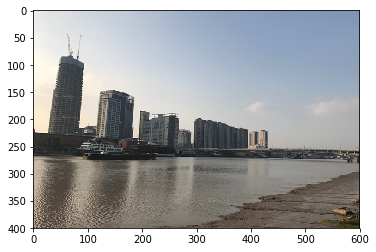

In [3] used 30.8125 MiB RAM in 0.74s, peaked 42.88 MiB above current, total RAM usage 214.09 MiB


In [3]:
# no pytorch involved starting from here
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline

# load model
qq = pickle.load(open( "model.pkl", "rb" ))

# for this particular example, scale the image to height=400 and width=600
content_image = Image.open("river.jpg")
content_image = content_image.resize((600, 400), Image.ANTIALIAS)
imshow(content_image)

# transform image to a 1*3*400*600 array
pix = np.array(content_image).transpose(2,0,1)[np.newaxis,:].astype(np.float32)

In [4]:
qq

{'conv1.conv2d.weight': array([[[[ 1.02541531e-02, -1.91261601e-02, -6.92134127e-02, ...,
           -6.30111620e-02,  2.23783869e-02,  5.16053513e-02],
          [-7.91794360e-02,  2.23170617e-04,  5.55464160e-03, ...,
            1.50148384e-02,  6.87683225e-02,  1.42189283e-02],
          [-1.22179342e-02,  5.69067849e-03, -5.61674731e-03, ...,
            8.44907612e-02,  9.09233987e-02,  4.44173291e-02],
          ...,
          [ 4.51586396e-02, -1.39633641e-02, -5.54998522e-04, ...,
           -9.35786813e-02,  7.48802796e-02,  7.77862221e-02],
          [-1.57422125e-02,  1.28025515e-02, -1.65449809e-02, ...,
            9.31329839e-03,  1.32022440e-01,  6.87308386e-02],
          [ 3.17232199e-02, -7.18512312e-02, -3.89899127e-02, ...,
           -9.61365923e-03,  3.48366462e-02,  1.51504306e-02]],
 
         [[ 2.37912145e-02,  4.55994383e-02, -4.92992550e-02, ...,
           -1.19451275e-02,  8.25757068e-03, -3.06168967e-03],
          [ 6.98505491e-02, -3.36327478e-02, -3.9

In [4] used 1.1016 MiB RAM in 0.35s, peaked 0.00 MiB above current, total RAM usage 215.19 MiB


In [5]:
%load_ext Cython

In [5] used 7.9531 MiB RAM in 0.47s, peaked 0.00 MiB above current, total RAM usage 223.14 MiB


In [6]:
%%cython 
import numpy as np
cimport numpy as np
cimport cython

DTYPE = np.float32
ctypedef np.float32_t DTYPE_t

# this function is for fast im2col based on cython
# original code is from https://github.com/samehkhamis/pydeeplearn/blob/master/pydeeplearn/image/image.pyx
# modified the original code slightly
@cython.boundscheck(False)
@cython.wraparound(False)
def im2col(np.ndarray[DTYPE_t, ndim=4] im, int filterH, int filterW, int padding, int stride):
    cdef int N = im.shape[0], C = im.shape[1], H = im.shape[2], W = im.shape[3]
    cdef np.ndarray[DTYPE_t, ndim=4] im_padded = np.empty((N, C, H + 2 * padding, W + 2 * padding), dtype=DTYPE)
    if padding > 0:
        im_padded[:, :, padding:-padding, padding:-padding] = im
        im_padded[:, :, :padding, :] = 0
        im_padded[:, :, -padding:, :] = 0
        im_padded[:, :, :, :padding] = 0
        im_padded[:, :, :, -padding:] = 0
    else:
        im_padded[:] = im
    
    cdef int newH = (H + 2 * padding - filterH) // stride + 1
    cdef int newW = (W + 2 * padding - filterW) // stride + 1
    
    cdef np.ndarray[DTYPE_t, ndim=2] col = np.empty((C * filterH * filterW, N * newH * newW), dtype=DTYPE)
    cdef int i, hj, wj, ci, hi, wi, c, r
    
    for i in range(N):
        for hj in range(newH):
            for wj in range(newW):
                c = i * newH * newH + hj * newW + wj
                for hi in range(filterH):
                    for wi in range(filterW):
                        for ci in range(C):
                            r = ci * filterW * filterH + hi * filterW + wi
                            col[r, c] = im_padded[i, ci, stride * hj + hi, stride * wj + wi]
    return col

# this function applies weights to the output of im2col function
# mainly to reduce the memory usage, but will take longer time than using numpy matrix multiplication
@cython.boundscheck(False)
@cython.wraparound(False)
def im2col_transfer(np.ndarray[DTYPE_t, ndim=4] im, int filterH, int filterW, int padding, int stride, 
                    np.ndarray[DTYPE_t, ndim=2] weight):
    cdef int N = im.shape[0], C = im.shape[1], H = im.shape[2], W = im.shape[3], OH = weight.shape[0]
    cdef np.ndarray[DTYPE_t, ndim=4] im_padded = np.empty((N, C, H + 2 * padding, W + 2 * padding), dtype=DTYPE)
    if padding > 0:
        im_padded[:, :, padding:-padding, padding:-padding] = im
        im_padded[:, :, :padding, :] = 0
        im_padded[:, :, -padding:, :] = 0
        im_padded[:, :, :, :padding] = 0
        im_padded[:, :, :, -padding:] = 0
    else:
        im_padded[:] = im
    
    cdef int newH = (H + 2 * padding - filterH) // stride + 1
    cdef int newW = (W + 2 * padding - filterW) // stride + 1
    
    cdef np.ndarray[DTYPE_t, ndim=2] col = np.empty((OH, N * newH * newW), dtype=DTYPE)
    cdef int i, hj, wj, ci, hi, wi, c, r, oi
    cdef double d
    
    for i in range(N):
        for hj in range(newH):
            for wj in range(newW):
                c = i * newH * newH + hj * newW + wj
                for oi in range(OH):
                    d = 0
                    for hi in range(filterH):
                        for wi in range(filterW):
                            for ci in range(C):
                                r = ci * filterW * filterH + hi * filterW + wi
                                d += im_padded[i, ci, stride * hj + hi, stride * wj + wi] * weight[oi, r]
                    col[oi, c] = d
    return col

In [6] used 0.5078 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 223.65 MiB


In [7]:
def style_transfer(pix, style_id):
    # 243 * 240000
    y = im2col(pix, 9, 9, 4, 1)
    # 32 * 243
    w = qq["conv1.conv2d.weight"].reshape(32, -1)
    # 32 * 240000
    y = w @ y + qq["conv1.conv2d.bias"].reshape(32, -1)
    # 32 * 240000
    y = (y - y.mean(axis=1).reshape(32, -1))/y.std(axis=1).reshape(32, -1) \
        * qq["in1.inns.{}.weight".format(style_id)].reshape(32, -1) \
        + qq["in1.inns.{}.bias".format(style_id)].reshape(32, -1)
    y = y * (y > 0)
    y = y.reshape(1, 32, 400, 600)

    #### conv layer 2
    y = im2col(y, 3, 3, 1, 2)
    w = qq["conv2.conv2d.weight"].reshape(64, -1)
    y = w @ y + qq["conv2.conv2d.bias"].reshape(64, -1)
    y = (y - y.mean(axis=1).reshape(64, -1))/y.std(axis=1).reshape(64, -1) \
        * qq["in2.inns.{}.weight".format(style_id)].reshape(64, -1) \
        + qq["in2.inns.{}.bias".format(style_id)].reshape(64, -1)
    y = y * (y > 0)
    y = y.reshape(1, 64, 200, 300)

    # #### conv layer 3
    y= im2col(y, 3, 3, 1, 2)
    w = qq["conv3.conv2d.weight"].reshape(128, -1)
    y = w @ y + qq["conv3.conv2d.bias"].reshape(128, -1)
    y = (y - y.mean(axis=1).reshape(128, -1))/y.std(axis=1).reshape(128, -1) \
        * qq["in3.inns.{}.weight".format(style_id)].reshape(128, -1) \
        + qq["in3.inns.{}.bias".format(style_id)].reshape(128, -1)
    y = y * (y > 0)
    y = y.reshape(1, 128, 100, 150)
    
    #### five residual layers
    for i in range(1,6):
        res = y
        y = im2col(y, 3, 3, 1, 1)
        w = qq["res{}.conv1.conv2d.weight".format(i)].reshape(128, -1)
        y = w @ y + qq["res{}.conv1.conv2d.bias".format(i)].reshape(128, -1)
        y = (y - y.mean(axis=1).reshape(128, -1))/y.std(axis=1).reshape(128, -1) \
            * qq["res{}.in1.weight".format(i)].reshape(128, -1) \
            + qq["res{}.in1.bias".format(i)].reshape(128, -1)
        y = y * (y > 0)
        y = y.reshape(1, 128, 100, 150)

        y = im2col(y, 3, 3, 1, 1)
        w = qq["res{}.conv2.conv2d.weight".format(i)].reshape(128, -1)
        y = w @ y + qq["res{}.conv2.conv2d.bias".format(i)].reshape(128, -1)
        y = (y - y.mean(axis=1).reshape(128, -1))/y.std(axis=1).reshape(128, -1) \
            * qq["res{}.in2.weight".format(i)].reshape(128, -1) \
            + qq["res{}.in2.bias".format(i)].reshape(128, -1)
        y = y.reshape(1, 128, 100, 150) + res

    #### deconv layer 1 
    y = y.repeat(2, axis=2).repeat(2, axis=3)
    y = im2col_transfer(y, 3, 3, 1, 1, qq["deconv1.conv2d.weight"].reshape(64, -1)) \
        + qq["deconv1.conv2d.bias"].reshape(64, -1)
    y = (y - y.mean(axis=1).reshape(64, -1))/y.std(axis=1).reshape(64, -1) \
        * qq["in4.inns.{}.weight".format(style_id)].reshape(64, -1) \
        + qq["in4.inns.{}.bias".format(style_id)].reshape(64, -1)
    y = y * (y > 0)
    y = y.reshape(1, 64, 200, 300)

    #### deconv layer 2 
    y = y.repeat(2, axis=2).repeat(2, axis=3)
    y = im2col_transfer(y, 3, 3, 1, 1, qq["deconv2.conv2d.weight"].reshape(32, -1)) \
        + qq["deconv2.conv2d.bias"].reshape(32, -1)
    y = (y - y.mean(axis=1).reshape(32, -1))/y.std(axis=1).reshape(32, -1) \
        * qq["in5.inns.{}.weight".format(style_id)].reshape(32, -1) \
        + qq["in5.inns.{}.bias".format(style_id)].reshape(32, -1)
    y = y * (y > 0)
    y = y.reshape(1, 32, 400, 600)

    #### deconv layer 3
    y = im2col_transfer(y, 9, 9, 4, 1, qq["deconv3.conv2d.weight"].reshape(3, -1)) \
        + qq["deconv3.conv2d.bias"].reshape(3, -1)
    out = np.clip(y.reshape(3,400,600).transpose(1,2,0), 0, 255).astype("uint8")
    return Image.fromarray(out)

In [7] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 223.65 MiB


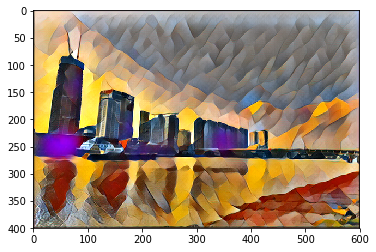

In [8] used 21.6367 MiB RAM in 13.48s, peaked 207.55 MiB above current, total RAM usage 245.29 MiB


In [8]:
# pick any style id from 0 to 18
img = style_transfer(pix, 16)
imshow(img)